In [1]:
%cd ~/Workspace/kaggle-2019Q3-cellular/

/home/chengjiun/Workspace/kaggle-2019Q3-cellular


In [2]:
import os
import numpy as np
import pandas as pd

from fastai.vision import *
BASE_DIR = '/media/chengjiun/data/kaggle-2019Q3-rcic/'

In [3]:
import cv2

In [4]:
#lazy calculation of stats
pixel_stats = pd.read_csv(f'{BASE_DIR}/pixel_stats.csv')
channel1_mean = pixel_stats.iloc[::6,:]['mean'].mean()
channel2_mean = pixel_stats.iloc[1::6,:]['mean'].mean()
channel3_mean = pixel_stats.iloc[2::6,:]['mean'].mean()
channel4_mean = pixel_stats.iloc[3::6,:]['mean'].mean()
channel5_mean = pixel_stats.iloc[4::6,:]['mean'].mean()
channel6_mean = pixel_stats.iloc[5::6,:]['mean'].mean()


channel1_std = pixel_stats.iloc[::6,:]['std'].mean()
channel2_std = pixel_stats.iloc[1::6,:]['std'].mean()
channel3_std = pixel_stats.iloc[2::6,:]['std'].mean()
channel4_std = pixel_stats.iloc[3::6,:]['std'].mean()
channel5_std = pixel_stats.iloc[4::6,:]['std'].mean()
channel6_std = pixel_stats.iloc[5::6,:]['std'].mean()
stats = (torch.Tensor([channel1_mean,channel2_mean,channel3_mean,channel4_mean,channel5_mean,channel6_mean])/255,torch.Tensor([channel1_std,channel2_std,channel3_std,channel4_std,channel5_std,channel6_std])/255)
print(stats)

(tensor([0.0229, 0.0611, 0.0396, 0.0391, 0.0219, 0.0356]), tensor([0.0271, 0.0492, 0.0219, 0.0292, 0.0183, 0.0193]))


## Loading and formatting data

Here I will load the csv into the DataFrame, and create a column in the DataFrame with the path to the corresponding image (`generate_df`)

In [5]:
train_df = pd.read_csv(f'{BASE_DIR}/train.csv')
train_df.head(10)

,id_code,experiment,plate,well,sirna
0,HEPG2-01_1_B03,HEPG2-01,1,B03,513
1,HEPG2-01_1_B04,HEPG2-01,1,B04,840
2,HEPG2-01_1_B05,HEPG2-01,1,B05,1020
3,HEPG2-01_1_B06,HEPG2-01,1,B06,254
4,HEPG2-01_1_B07,HEPG2-01,1,B07,144
5,HEPG2-01_1_B08,HEPG2-01,1,B08,503
6,HEPG2-01_1_B09,HEPG2-01,1,B09,188
7,HEPG2-01_1_B10,HEPG2-01,1,B10,700
8,HEPG2-01_1_B11,HEPG2-01,1,B11,1100
9,HEPG2-01_1_B12,HEPG2-01,1,B12,611


In [6]:
def generate_df(train_df,sample_num=1):
    train_df['path'] = train_df['experiment'].str.cat(train_df['plate'].astype(str).str.cat(train_df['well'],sep='/'),sep='/Plate') + '_s'+str(sample_num) + '_w'
    train_df = train_df.drop(columns=['id_code','experiment','plate','well']).reindex(columns=['path','sirna'])
    return train_df
proc_train_df = generate_df(train_df)
proc_train2_df = generate_df(train_df, sample_num=2)

In [7]:
proc_train_all_df = pd.concat([proc_train_df, proc_train2_df], axis=0, ignore_index=True,sort=True)
print(proc_train_df.shape, proc_train2_df.shape, proc_train_all_df.shape)
proc_train_df.head()


(36515, 2) (36515, 2) (73030, 2)


,path,sirna
0,HEPG2-01/Plate1/B03_s1_w,513
1,HEPG2-01/Plate1/B04_s1_w,840
2,HEPG2-01/Plate1/B05_s1_w,1020
3,HEPG2-01/Plate1/B06_s1_w,254
4,HEPG2-01/Plate1/B07_s1_w,144


Let's look at an example image. These images are 6-channel images, but the each of the six channels are saved as separate files. Here, I open just one channel of the image.

In fastai, there is a modular data API that allows you to easily load images, add labels, split into train/valid, and add transforms. The base class for loading the images is an `ItemList`. For image classification tasks, the base class is `ImageList` which in turn subclasses the `ItemList` class. Since `ImageList` can only open 3-channel images, we will define a new `ImageList` class where we redefine the loading function:

In [8]:
def open_rcic_image(fn):
    images = []
    for i in range(6):
        file_name = fn+str(i+1)+'.png'
        im = cv2.imread(file_name)
        if im is None: 
            print(f'file reading failed {file_name}')
        
        im = cv2.cvtColor(im, cv2.COLOR_RGB2GRAY)
        images.append(im)
    image = np.dstack(images)
    #print(pil2tensor(image, np.float32).shape)#.div_(255).shape)
    return Image(pil2tensor(image, np.float32).div_(255))
  
class MultiChannelImageList(ImageList):
    def open(self, fn):
        return open_rcic_image(fn)

As I subclassed the ImageList function I can load images with the `ImageList` function `.from_df`. 

In [9]:
il = MultiChannelImageList.from_df(df=proc_train_df,path=f'{BASE_DIR}/train/')

We have to redefine the following function to be able to view the image in the notebook. I view just the first 3 channels.

In [10]:
def image2np(image:Tensor)->np.ndarray:
    "Convert from torch style `image` to numpy/matplotlib style."
    res = image.cpu().permute(1,2,0).numpy()
    if res.shape[2]==1:
        return res[...,0]  
    elif res.shape[2]>3:
        #print(res.shape)
        #print(res[...,:3].shape)
        return res[...,:3]
    else:
        return res

vision.image.image2np = image2np

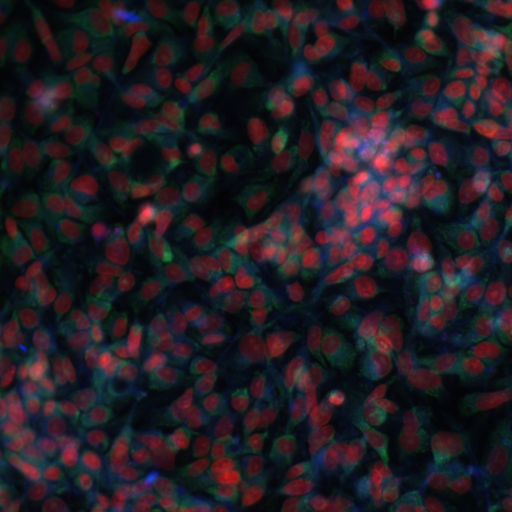

In [11]:
il[0]

## Creating and Training a Model

I will use a pretrained ResNet. I have to now adjust the CNN arch to take in 6 channels as opposed to the usual 3 channels:

In [11]:
"""Inspired by https://github.com/wdhorton/protein-atlas-fastai/blob/master/resnet.py"""

import torchvision
RESNET_MODELS = {
    34: torchvision.models.resnet34,
    50: torchvision.models.resnet50,
    101: torchvision.models.resnet101,
    152: torchvision.models.resnet152,
    '101x': torchvision.models.resnext101_32x8d,
}
# from utils import accuracy
"""From https://www.kaggle.com/leighplt/densenet121-pytorch"""
def accuracy(output, target, topk=(1,)):
    """Computes the accuracy over the k top predictions for the specified values of k"""
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].view(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size).item())
        return torch.Tensor(np.array(res))


def resnet_multichannel(depth=50,pretrained=True,num_classes=1108,num_channels=6):
        model = RESNET_MODELS[depth](pretrained=pretrained)
        w = model.conv1.weight
        model.conv1 = nn.Conv2d(num_channels, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        model.conv1.weight = nn.Parameter(torch.cat((w,torch.zeros(64,num_channels-3,7,7)),dim=1))
        return model

def resnet34(pretrained,num_channels=6):
    return resnet_multichannel(depth=50,pretrained=pretrained,num_channels=num_channels)

def resnet50(pretrained,num_channels=6):
    return resnet_multichannel(depth=50,pretrained=pretrained,num_channels=num_channels)

def resnext101(pretrained,num_channels=6):
    return resnet_multichannel(depth='101x',pretrained=pretrained,num_channels=num_channels)
def _resnet_split(m): return (m[0][6],m[1])

In [12]:
import fastai, torch
print(fastai.__version__, torch.__version__)

1.0.57 1.2.0


Let's create our Learner:

In [28]:
cnn_learner??

In [ ]:
# resnext101 fp16, size=256, bs=80
# resnext101 fp16, size=512, bs=80

sample_df = proc_train_all_df.iloc[:800]
data = (MultiChannelImageList.from_df(df=proc_train_all_df,path=f'{BASE_DIR}/train/')
        .split_by_rand_pct(0.2)
        .label_from_df()
        .transform(get_transforms(),size=256)
        .databunch(bs=80,num_workers=8) 
        .normalize(stats)
       )

learn = cnn_learner(data,resnext101,cut=-2,split_on=_resnet_split,metrics=[accuracy])
learn.path = Path('./fastaimodels/')
learn = learn.to_fp16()
learn.model = torch.nn.DataParallel(learn.model, device_ids=[0, 1])

We can now find the appropriate learning rate and train the head of the model:

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 1.91E-03


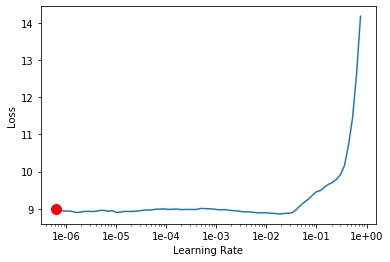

In [18]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [13]:
learn.fit_one_cycle(5,slice(1e-4,1e-2))

epoch,train_loss,valid_loss,accuracy,time
0,6.489816,6.130715,2.978228,28:03
1,5.668761,5.334038,8.195262,39:46
2,4.981153,4.515264,17.383266,56:12
3,4.370513,3.916327,25.920855,56:17
4,3.999739,3.731815,28.351362,56:09


In [14]:
learn.save('resnext101-stage-1')
learn.export()

We will now unfreeze and train the entire model.

In [ ]:
learn.loadd('resnext101-stage-1')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.10E-06
Min loss divided by 10: 1.20E-06


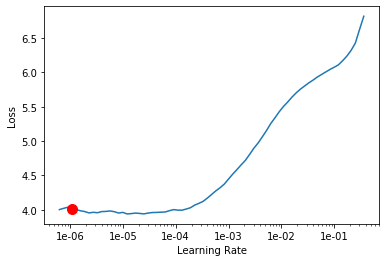

In [15]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [16]:
learn.fit_one_cycle(10,slice(1e-6,4e-5))

epoch,train_loss,valid_loss,accuracy,time
0,3.881301,3.714488,28.885389,40:52
1,3.872243,3.698024,28.803232,56:13
2,3.845779,3.620332,29.932905,56:11
3,3.775888,3.525505,31.528139,56:04
4,3.588866,3.474725,32.055321,55:58
5,3.520604,3.402516,33.499931,55:58
6,3.489136,3.377513,33.958649,56:02
7,3.385777,3.337904,34.561138,55:46
8,3.330881,3.324943,34.745995,56:04


KeyboardInterrupt: 

In [17]:
learn.save('resnext101-stage-2')
learn.export()

In [15]:
learn.load('resnext101-stage-2')

Learner(data=ImageDataBunch;

Train: LabelList (58424 items)
x: MultiChannelImageList
Image (6, 256, 256),Image (6, 256, 256),Image (6, 256, 256),Image (6, 256, 256),Image (6, 256, 256)
y: CategoryList
513,840,254,144,503
Path: /media/chengjiun/data/kaggle-2019Q3-rcic/train;

Valid: LabelList (14606 items)
x: MultiChannelImageList
Image (6, 256, 256),Image (6, 256, 256),Image (6, 256, 256),Image (6, 256, 256),Image (6, 256, 256)
y: CategoryList
46,396,836,392,829
Path: /media/chengjiun/data/kaggle-2019Q3-rcic/train;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(6, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): Ba

In [16]:
learn.unfreeze()
learn.fit_one_cycle(10,1e-5)

epoch,train_loss,valid_loss,accuracy,time
0,3.550301,2.749062,46.535671,52:56
1,3.586711,2.750717,46.309734,55:55
2,3.546623,2.769597,45.707245,56:08
3,3.474006,2.754972,46.350815,56:05
4,3.351296,2.708018,46.528824,55:53
5,3.278311,2.690968,46.768452,55:46
6,3.207858,2.621904,48.028206,55:49
7,3.090727,2.589249,48.925098,55:44
8,3.052385,2.577819,49.287964,55:38
9,3.098090,2.568627,49.055183,55:26


In [17]:
learn.save('resnext101-stage-3')
learn.export()

In [ ]:
!sudo shutdown -h now

## Inference and Submission Generation

Let's now load our test csv and process the DataFrame like we did for the training data.

We add the data to our DataBunch:

In [18]:
test_df = pd.read_csv(f'{BASE_DIR}/test.csv')
proc_test_df = generate_df(test_df.copy(), sample_num=1)
data_test = MultiChannelImageList.from_df(df=proc_test_df,path=f'{BASE_DIR}/test/')
learn.data.add_test(data_test)

Now we can get out predictions on the test set.

In [19]:
preds, _ = learn.get_preds(DatasetType.Test)
preds_ = preds.argmax(dim=-1)

In [20]:
proc_test_df = generate_df(test_df.copy(), sample_num=2)
data_test = MultiChannelImageList.from_df(df=proc_test_df,path=f'{BASE_DIR}/test/')
learn.data.add_test(data_test)

In [21]:
preds2, _ = learn.get_preds(DatasetType.Test)
preds2_ = preds2.argmax(dim=-1)

In [22]:
preds_mean = (preds + preds2)/2.

In [23]:
test_df.head(10)

,id_code,experiment,plate,well
0,HEPG2-08_1_B03,HEPG2-08,1,B03
1,HEPG2-08_1_B04,HEPG2-08,1,B04
2,HEPG2-08_1_B05,HEPG2-08,1,B05
3,HEPG2-08_1_B06,HEPG2-08,1,B06
4,HEPG2-08_1_B07,HEPG2-08,1,B07
5,HEPG2-08_1_B08,HEPG2-08,1,B08
6,HEPG2-08_1_B09,HEPG2-08,1,B09
7,HEPG2-08_1_B10,HEPG2-08,1,B10
8,HEPG2-08_1_B11,HEPG2-08,1,B11
9,HEPG2-08_1_B12,HEPG2-08,1,B12


Let's open the sample submission file and load it with our predictions to create a submission.

In [24]:
submission_df = pd.read_csv(f'{BASE_DIR}/sample_submission.csv')

In [30]:
submission_df.sirna = preds_.numpy().astype(int)
submission_df.head(10)

,id_code,sirna
0,HEPG2-08_1_B03,407
1,HEPG2-08_1_B04,704
2,HEPG2-08_1_B05,57
3,HEPG2-08_1_B06,899
4,HEPG2-08_1_B07,70
5,HEPG2-08_1_B08,981
6,HEPG2-08_1_B09,216
7,HEPG2-08_1_B10,638
8,HEPG2-08_1_B11,154
9,HEPG2-08_1_B12,1090


In [26]:
submission_df.to_csv('submission-resnet101-singlesite.csv',index=False)

In [33]:
preds_mean_ = preds_mean.argmax(dim=-1)
submission_df['sirna2'] = preds_mean_.numpy().astype(int)
submission_df.head(10)

,id_code,sirna,sirna2
0,HEPG2-08_1_B03,407,407
1,HEPG2-08_1_B04,704,19
2,HEPG2-08_1_B05,57,623
3,HEPG2-08_1_B06,899,899
4,HEPG2-08_1_B07,70,989
5,HEPG2-08_1_B08,981,981
6,HEPG2-08_1_B09,216,216
7,HEPG2-08_1_B10,638,287
8,HEPG2-08_1_B11,154,154
9,HEPG2-08_1_B12,1090,1090


In [34]:
(submission_df['sirna'] != submission_df['sirna2']).mean()

0.3753329647685581

In [29]:
submission_df.to_csv('submission-resnet101-doublesite.csv',index=False)

# postprocess

In [35]:
sub_df = pd.read_csv(f'{BASE_DIR}/sample_submission.csv')

In [39]:
plate_groups = np.zeros((1108,4), int)
for sirna in range(1108):
    grp = train_df.loc[train_df.sirna==sirna,:].plate.value_counts().index.values
    assert len(grp) == 3
    plate_groups[sirna,0:3] = grp
    plate_groups[sirna,3] = 10 - grp.sum()
    
plate_groups[:10,:]


all_test_exp = test_df.experiment.unique()

group_plate_probs = np.zeros((len(all_test_exp),4))
for idx in range(len(all_test_exp)):
    preds = sub_df.loc[test_df.experiment == all_test_exp[idx],'sirna'].values
    pp_mult = np.zeros((len(preds),1108))
    pp_mult[range(len(preds)),preds] = 1
    
    sub_test = test_df.loc[test_df.experiment == all_test_exp[idx],:]
    assert len(pp_mult) == len(sub_test)
    
    for j in range(4):
        mask = np.repeat(plate_groups[np.newaxis, :, j], len(pp_mult), axis=0) == \
               np.repeat(sub_test.plate.values[:, np.newaxis], 1108, axis=1)
        
        group_plate_probs[idx,j] = np.array(pp_mult)[mask].sum()/len(pp_mult)

exp_to_group = group_plate_probs.argmax(1)
print(exp_to_group)


def select_plate_group(pp_mult, idx, 
                       test_df=test_df, all_test_exp=all_test_exp, plate_groups=plate_groups,
                       exp_to_group=exp_to_group):
    sub_test = test_df.loc[test_df.experiment == all_test_exp[idx],:]
    assert len(pp_mult) == len(sub_test)
    mask = np.repeat(plate_groups[np.newaxis, :, exp_to_group[idx]], len(pp_mult), axis=0) != \
           np.repeat(sub_test.plate.values[:, np.newaxis], 1108, axis=1)
    pp_mult[mask] = 0
    return pp_mult

[1 0 0 2 0 0 0 0 0 0 3 1 0 0 0 2 0 0]


In [41]:
preds_mean.numpy().astype(int)

for idx in range(len(all_test_exp)):
    #print('Experiment', idx)
    indices = (test_df.experiment == all_test_exp[idx])
    
    preds_slice = preds_mean.numpy()[indices,:].copy()
    
    preds_slice = select_plate_group(preds_slice, idx, 
                                     test_df=test_df, all_test_exp=all_test_exp, plate_groups=plate_groups,
                                     exp_to_group=exp_to_group)
    sub_df.loc[indices,'sirna'] = preds_slice.argmax(1)

In [43]:
sub_df.to_csv('submission-resnet101-doublesite-boost.csv',index=False)
sub_df.head()

,id_code,sirna
0,HEPG2-08_1_B03,1087
1,HEPG2-08_1_B04,807
2,HEPG2-08_1_B05,86
3,HEPG2-08_1_B06,134
4,HEPG2-08_1_B07,989


## Future work:

This is only a simple baseline. There are many different things we can change:
* Use both sites (right now I only use site 1)
* Model architecture
* Train multiple classifiers for different cell types
* **Metric learning** - This will be the key to successful submissions